In [24]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
from openslide import OpenSlide
from matplotlib import pyplot as plt
import os
from skimage import measure
from copy import deepcopy
import cv2

In [25]:
# read annotation
csvobj = pd.read_pickle('1C1.pkl')
# read image size
impth = r'\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1\1C1.ndpi'
imageobj = OpenSlide(impth)
image_size = imageobj.dimensions
(width,height) = image_size
img = Image.new('L', (round(width), round(height)), 0) #0 for default pixel value

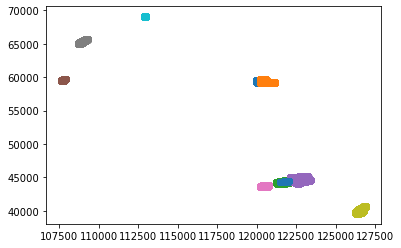

In [26]:
iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]
for i in iter_order:
    row = csvobj.iloc[i - 1]
    color = i
    xycoord = np.squeeze(row['Coord'].astype('uint32'))
    plt.scatter(xycoord[:,0],xycoord[:,1]) #(x,y) this is right because (0,0) is the bottom left of the plot
    xycoord = list(zip(xycoord[:,0],xycoord[:,1])) #turn [[,]] into tuples (x,y)
    ImageDraw.Draw(img).polygon(xycoord, outline=None, fill=color) #this fill value should be class ID

In [27]:
img2 = img.resize((round(width/10),round(height/10)),resample=0) #nearest method to preserve pixel value, 0=NEAREST
dstfn = '1C1.png'
img2.save(dstfn)

In [28]:
# open both wsi and annotation map
wsi_src = os.path.expanduser(r'\\fatherserverdw\Q\research\images\CLUE\3D study\he\c1')
wsi_fn = '1C1.ndpi'
wsipath = os.path.join(wsi_src, wsi_fn)

#anno_src = os.path.expanduser(r'\\Users\kyuha\PycharmProjects\wsi_analysis\ashley')
#anno_fn = '1C1temp.png'
#annotation_map_path = os.path.join(anno_src, anno_fn)
wsi = OpenSlide(wsipath)
annotation = Image.open('1C1.png') #convert to greyscale?

In [42]:
# iterate each class and each annotation object to make a crop
for classid in iter_order:
    annotation2crop = np.zeros_like(annotation)
    #all annotation for the current class id
    annotation2crop[np.array(annotation) == classid] = 1
    labeled_map = measure.label(annotation2crop)
    #regionprops has properties of the label
    regionprops = measure.regionprops(labeled_map)
    #bounboxes is a tuple, (min_row, min_col, max_row, max_col)
    boundboxes = list()
    for region in regionprops[0:1]:
        boundboxes.append(region.bbox)


    for objID, boundbox in enumerate(boundboxes[0:1]):
        #crop at the boundaries
        objmask =  deepcopy(labeled_map)
        objmask[objmask!=objID+1] = 0
        objmask[objmask==objID+1] = 1
        boundbox = [_*10 for _ in boundbox] #enlarge by 10, og boundbox



        #TODO: convert boundbox1 to level 2
        #conversion ratio
        rsf = int(wsi.level_downsamples[2])
        boundbox1 = np.multiply(boundbox,rsf)

        objmask = objmask[boundbox[0]:boundbox[2],boundbox[1]:boundbox[3]]
        h,w= boundbox[2]-boundbox[0], boundbox[3]-boundbox[1]

        #read cropped region
        imcrop = wsi.read_region(location=(boundbox[1],boundbox[0]),level=0,size=(w,h)).convert('RGB') #use level 2, more zoomed in
        imcrop = np.array(imcrop)

        #create mask to crop out the extra space around the annotation
        objmask = deepcopy(labeled_map)
        objmask[objmask!=1] = 0
        objmask[objmask==1] = 1
        boundbox = [round(_/10) for _ in boundbox] #downsize by 10
        objmask2 = objmask[boundbox[0]:boundbox[2],boundbox[1]:boundbox[3]] #crop out the objmask2, typecast to integer

        #enlarge objmask2 by 10 to get objmask3, take transpose of objmask3 to get objmask4
        new_shape = list(objmask2.shape)
        new_shape = [_*10 for _ in new_shape]
        objmask3 = cv2.resize(objmask2.astype(np.float),tuple(new_shape), interpolation = cv2.INTER_NEAREST) #NEAREST preserves pixel value


        #TODO: smooth objmask 3, (try fillConvexPoly method for python (convex hull)???)
        #trying to loop through each pixel and add new pixel in between
        #objmask3 is a binary image array filled with 0 and 1s
        for pix in objmask3: 








        objmask4 = np.dstack([objmask3.transpose()]*3) #change shape of objmask3

        objmask3[objmask3==1]=classid #Question: what does this do again?

        #crop out the area outside the annotation using multiplication
        imcrop_masked = np.multiply(objmask4,imcrop)

        #Image.fromarray((imcrop_masked).astype(np.uint8)).save('imcrop/class{}_obj{}.png'.format(classid,objID))
        #Image.fromarray(objmask3.astype(np.uint8)).save('mskcrop/class{}_obj{}.png'.format(classid,objID))

TypeError: 'tuple' object is not callable